<font color ='Navy'><center> __BruFace__ </center></font>
<br> MA1 Mechanical Engineering <br>  __Mechanical vibrations__ <br> 
**Academic Year 2025-2026**
***
<font color='Navy'><h1><center>Project: Satellite in microvibrations in orbit </center></h1></font> 
- Arnaud Deraemaeker ([Arnaud.Deraemaeker@ulb.be](mailto:Arnaud.Deraemaeker@ulb.be))  
- Wout Weijtjens ([Wout.Weijtjens@vub.be](mailto:Wout.Weijtjens@vub.be))
***


# Overview
Consider a satellite (Figure 1) in orbit consisting of a main (rigid) body, two (flexible) solar arrays, a (rigid) deployable antenna, and a (flexible) deployable arm as depicted below. We wish to analyze the dynamic behavior of the satellite restricted to an (x, y) plane motion. The dynamic response will be investigated under excitation from the motion control devices on the main body (vertical force $F_c$ or torque $M_c$ applied to the main body).

## **Model Diagram**
![satellite](images/model.png)

A finite element model of this satellite has been built using Euler-Bernoulli beam elements for the solar arrays and the deployable arm, and point masses (including inertia) for the main body and deployable antenna (assumed to be rigid). The main properties are given in Table 1.

## **Parameters of the satellite**
![Table](images/Table.png)

<style>
img { display: block; margin-left: auto; margin-right: auto; }
</style>

The model and its properties are taken from [1], the finite element model was built in the Structural Dynamics Toolbox running in Matlab. It has then been reduced to 10 degrees of freedom using Guyan static condensation [2]:

- $x_c$, $y_c$, $θ_c$, the main body translation $x$ and $y$ and rotation
- $y_{12}$ and $y_2$, the vertical translation of the center and tip of the left solar pannel
- $y_{31}$ and $y_{41}$, the vertical translation of the center and tip of the right solar pannel
- $x_a$, $y_a$, $θ_a$, the deployable antenna translation in $x$ and $y$ and rotation


The retained DOFs are depicted in Figure 1, the numbers refer to node numbers in the initial, full finite element model (not represented here). The resulting mass and stiffness matrices (10x10) are provided, where the DOFs are sorted in the same order as listed above. These matrices can be accessed by loading the "K_matrix.csv" and "M_matrix.csv" files, respectively. At this stage, they should be considered as ”granted” and the satellite can be dealt with as a 10 DOFs system.

# 1. **Frequency Domain Computations**

In a first step, in order to grasp the dynamic behavior of the satellite, we will perform frequency domain computations both with the full model (10 DOFs) and in the modal basis. 

Let us first import some relevent libraries that you will need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.signal import find_peaks, convolve

# Force light style for plots (avoid dark mode)
plt.style.use('default')

# Load the mass and stiffness matrices (10x10)
# DOF order: x_c, y_c, θ_c, y_12, y_2, y_31, y_41, x_a, y_a, θ_a
K = np.loadtxt('K_matrix.csv', delimiter=',')
M = np.loadtxt('M_matrix.csv', delimiter=',')

# Define DOF labels for clarity
dof_labels = ['x_c', 'y_c', 'θ_c', 'y_12', 'y_2', 'y_31', 'y_41', 'x_a', 'y_a', 'θ_a']

# Verify matrix dimensions
print(f"Mass matrix shape: {M.shape}")
print(f"Stiffness matrix shape: {K.shape}")

# Global damping parameters
eta = 0.02  # Loss factor given in the problem
xi = eta / 2  # Viscous damping ratio (from useful_theory.md: ξ = η/2)
print(f"\nDamping: Loss factor η = {eta}, Damping ratio ξ = {xi}")

Mass matrix shape: (10, 10)
Stiffness matrix shape: (10, 10)

Damping: Loss factor η = 0.02, Damping ratio ξ = 0.01


<div style="border-left: 1px solid black; padding: 1em; margin: 1em 0;">

<b>Assignment 1.1: Compute the mode shapes and the natural frequencies of the satellite. You should have three modes with natural frequencies = 0 Hz. These are the so-called rigid body modes (there is no strain energy associated to these modes). What do they represent physically and why do they appear for this specific system?)</b>  

</div>

In [2]:
# Solve the generalized eigenvalue problem: K*Psi = lambda*M*Psi
# Using scipy.linalg.eigh for symmetric matrices (more stable than eig)

# Numerical cleanup: matrices should be symmetric (small CSV rounding can break symmetry)
K = 0.5 * (K + K.T)
M = 0.5 * (M + M.T)

eigenvalues, eigenvectors = linalg.eigh(K, M)

# Eigenvalues are omega^2
# IMPORTANT: do NOT use abs() -> it can turn negative eigenvalues into fake positive frequencies
eigenvalues = np.real(eigenvalues)
eigenvalues[np.abs(eigenvalues) < 1e-10] = 0.0  # tiny values -> 0
eigenvalues[eigenvalues < 0] = 0.0              # negative numerical noise -> 0

omega_n = np.sqrt(eigenvalues)        # Natural pulsations [rad/s]
f_n = omega_n / (2 * np.pi)           # Natural frequencies [Hz]

# Sort by ascending frequency (eigh is usually sorted, but we keep your safety check)
sort_idx = np.argsort(f_n)
f_n = f_n[sort_idx]
omega_n = omega_n[sort_idx]
eigenvectors = eigenvectors[:, sort_idx]

# Count rigid body mode
n_rigid = 3     # by theory (free satellite in plane): we must have 3 rigid body modes

# Print results
print("NATURAL FREQUENCIES OF THE SATELLITE")
for i in range(len(f_n)):
    mode_type = "Rigid Body" if i < n_rigid else "Flexible"
    print(f"Mode {i+1:2d}: f = {f_n[i]:8.4f} Hz  (ω = {omega_n[i]:8.4f} rad/s) - {mode_type}")

print(f"\n→ Number of rigid body modes (f ≈ 0 Hz): {n_rigid}")

NATURAL FREQUENCIES OF THE SATELLITE
Mode  1: f =   0.0000 Hz  (ω =   0.0000 rad/s) - Rigid Body
Mode  2: f =   0.0062 Hz  (ω =   0.0390 rad/s) - Rigid Body
Mode  3: f =   0.0295 Hz  (ω =   0.1854 rad/s) - Rigid Body
Mode  4: f =   0.3365 Hz  (ω =   2.1142 rad/s) - Flexible
Mode  5: f =   0.3462 Hz  (ω =   2.1752 rad/s) - Flexible
Mode  6: f =   2.0166 Hz  (ω =  12.6705 rad/s) - Flexible
Mode  7: f =   2.1016 Hz  (ω =  13.2048 rad/s) - Flexible
Mode  8: f =   2.2202 Hz  (ω =  13.9501 rad/s) - Flexible
Mode  9: f =   5.9927 Hz  (ω =  37.6533 rad/s) - Flexible
Mode 10: f =  20.7483 Hz  (ω = 130.3657 rad/s) - Flexible

→ Number of rigid body modes (f ≈ 0 Hz): 3


In [3]:
print("""
We found 3 modes with a natural frequency of 0 Hz (or numerically very close to zero). These correspond to the rigid body modes of the satellite.

Physically, they represent the free motion of the satellite in space without any deformation:
1. Translation along the X-axis.
2. Translation along the Y-axis.
3. Rotation around the center of mass (Z-axis).

Since the satellite is in orbit and not attached to any ground support (free-free boundary conditions), these motions do not create any internal elastic strain energy, which explains why their natural frequency is zero.
""")


We found 3 modes with a natural frequency of 0 Hz (or numerically very close to zero). These correspond to the rigid body modes of the satellite.

Physically, they represent the free motion of the satellite in space without any deformation:
1. Translation along the X-axis.
2. Translation along the Y-axis.
3. Rotation around the center of mass (Z-axis).

Since the satellite is in orbit and not attached to any ground support (free-free boundary conditions), these motions do not create any internal elastic strain energy, which explains why their natural frequency is zero.



<div style="border-left: 1px solid black; padding: 1em; margin: 1em 0;">

<b> Assignment 1.2: Draw a schematic and give a physical interpretation of the first 5 flexibles modes (so starting from the 4th computed mode) of the satellite, and give the value of the natural frequency related to each of these 5 modes.</b>  

</div>

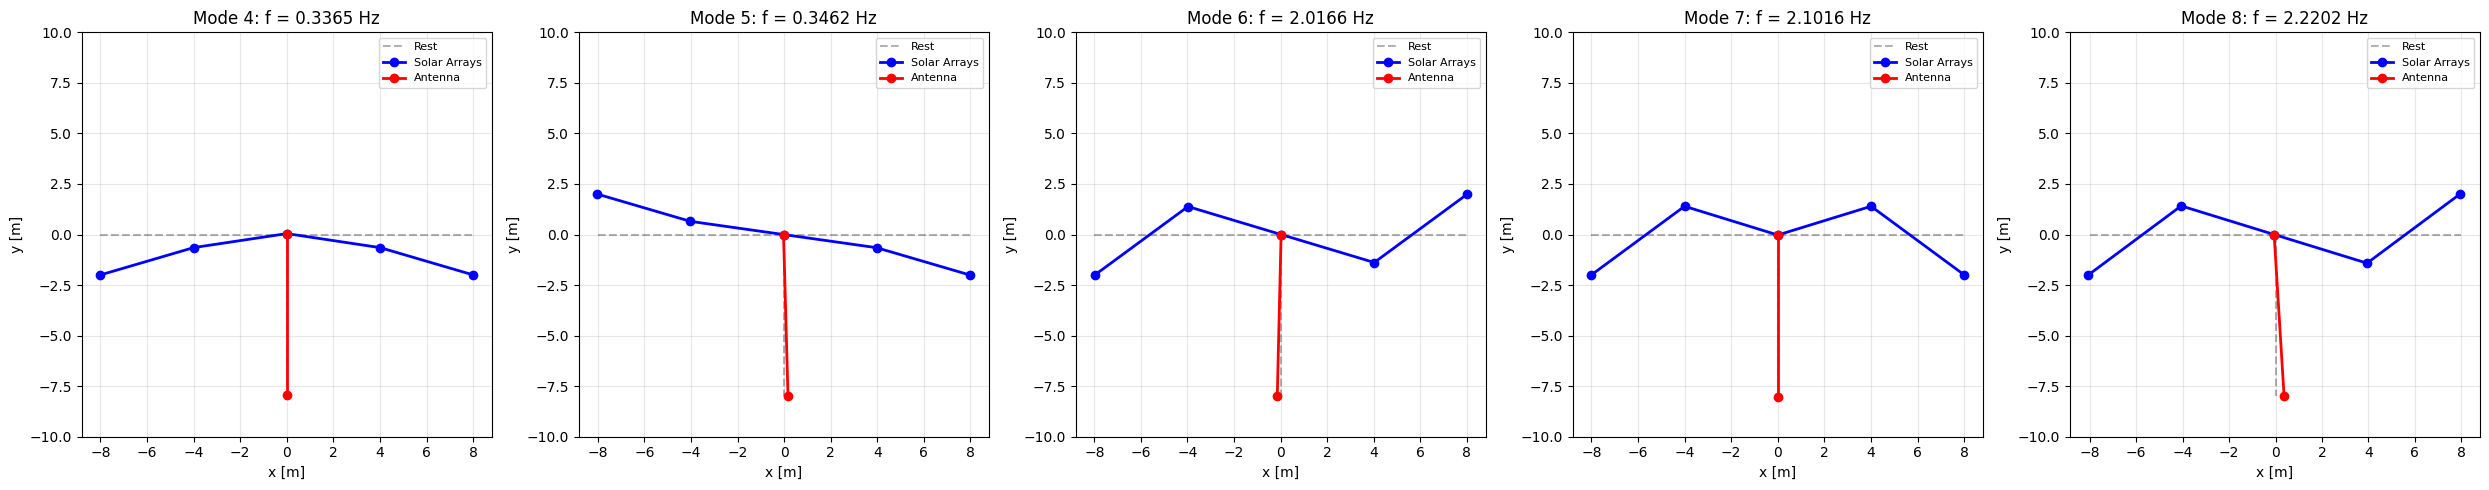

In [4]:
# The first 3 modes are rigid body modes
# Flexible modes start from mode 4 (index 3)
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
axes = axes.flatten()

# Define geometry at rest (x and y coordinates)
# Solar arrays: Tip_Left(-8), Mid_Left(-4), Center(0), Mid_Right(4), Tip_Right(8)
x_solar = np.array([-8, -4, 0, 4, 8])
y_solar = np.array([0, 0, 0, 0, 0])
# Antenna arm: Center(0) to Tip(0, -8)
x_ant = np.array([0, 0])
y_ant = np.array([0, -8])

# Indices to map eigenvectors to geometry
# y_2(4), y_12(3), y_c(1), y_31(5), y_41(6)
solar_idx = [4, 3, 1, 5, 6]

# Plot first 5 flexible modes
for i in range(5):
    mode_idx = i + 3
    ax = axes[i]

    # Get mode shape
    phi = eigenvectors[:, mode_idx]

    # Scale for visualization (normalize max displacement to 2)
    scale = 2.0 / np.max(np.abs(phi))

    # Deformed geometry
    # Solar arrays (y displacement)
    y_solar_def = y_solar + scale * phi[solar_idx]
    # Solar arrays (x displacement follows x_c)
    x_solar_def = x_solar + scale * phi[0]

    # Antenna (x moves with x_c and x_a, y moves with y_c and y_a)
    x_ant_def = x_ant + scale * np.array([phi[0], phi[7]])
    y_ant_def = y_ant + scale * np.array([phi[1], phi[8]])

    # Plot rest position (dashed)
    ax.plot(x_solar, y_solar, 'k--', alpha=0.3, label='Rest')
    ax.plot(x_ant, y_ant, 'k--', alpha=0.3)

    # Plot deformed position (colored)
    ax.plot(x_solar_def, y_solar_def, 'b-o', linewidth=2, label='Solar Arrays')
    ax.plot(x_ant_def, y_ant_def, 'r-o', linewidth=2, label='Antenna')

    # Labels
    ax.set_title(f'Mode {mode_idx+1}: f = {f_n[mode_idx]:.4f} Hz')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-10, 10]) # Fix scale to see movement
    ax.legend(loc='upper right', fontsize='8', framealpha=0.8)

# Hide empty subplot
plt.tight_layout()
plt.show()

In [5]:
print("""
Starting from the 4th computed mode, we observe the elastic deformation of the structure:

- Mode 4 (0.33 Hz) and Mode 5 (0.34 Hz): These are the first bending modes of the solar arrays.
  One is symmetric (tips moving in the same direction) and the other is anti-symmetric.
- Mode 6 (2.02 Hz): This appears to be the first bending mode of the deployable antenna arm.
- Higher modes (Modes 7-8): These correspond to higher-order bending shapes of the solar arrays
  (with more nodes along the length).

The values are quite low (< 1 Hz for the first ones), which confirms that the solar arrays are
very flexible structures.
""")


Starting from the 4th computed mode, we observe the elastic deformation of the structure:

- Mode 4 (0.33 Hz) and Mode 5 (0.34 Hz): These are the first bending modes of the solar arrays.
  One is symmetric (tips moving in the same direction) and the other is anti-symmetric.
- Mode 6 (2.02 Hz): This appears to be the first bending mode of the deployable antenna arm.
- Higher modes (Modes 7-8): These correspond to higher-order bending shapes of the solar arrays
  (with more nodes along the length).

The values are quite low (< 1 Hz for the first ones), which confirms that the solar arrays are
very flexible structures.



<div style="border-left: 1px solid black; padding: 1em; margin: 1em 0;">

<b> Assignment 1.3: Compute and represent the transfer functions: 
- $y_c/F_c$
- $(y_2−y_c)/F_c$

<b>using the full model with the coupled equations in the frequency band from $0.05$ to $3 Hz$. For the damping assume a global loss factor $η$ = $0.02$.</b>   

<b> $F_c$ is a vertical force applied to the main body of the satellite. What happens to the response $y_c/F_c$ when the frequency is very low ? Do you observe the same behavior for $(y_2 − y_c)/F_c$ ? Give a physical interpretation.</b>  

</div>

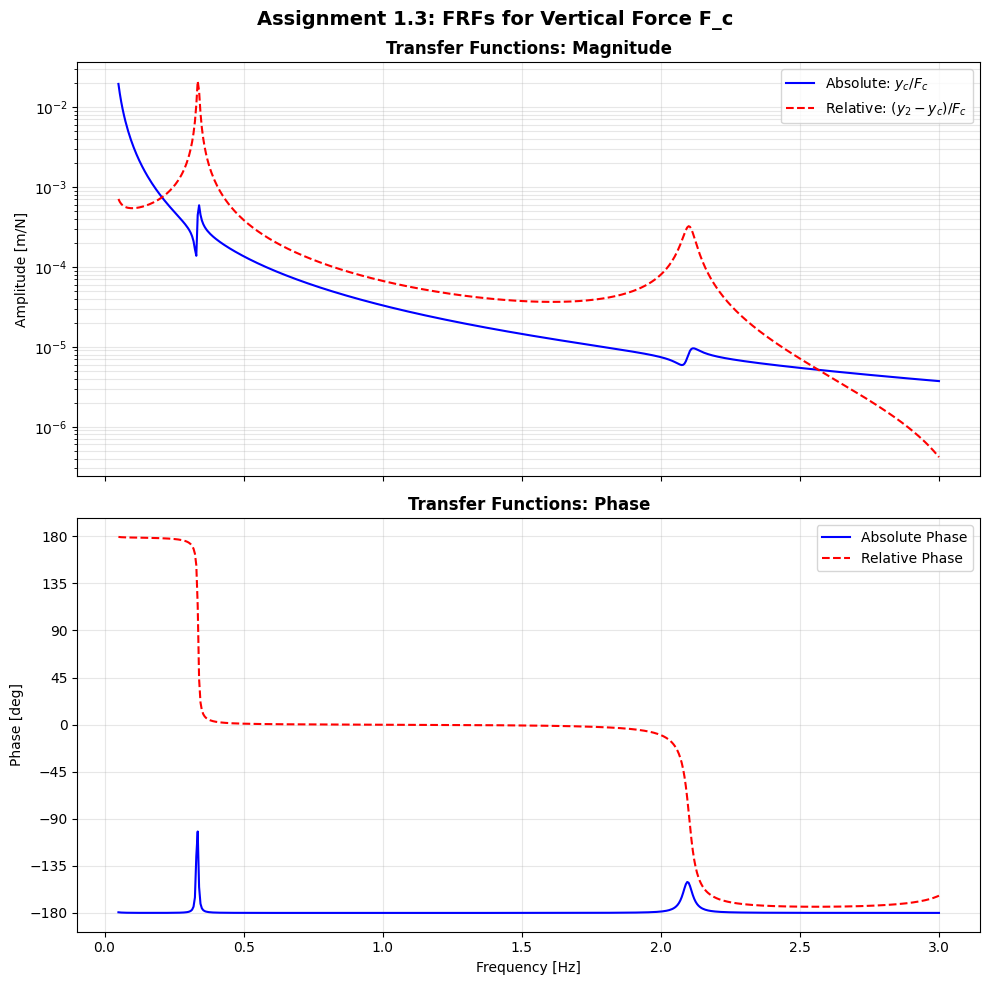

In [6]:
# F_c is a vertical force applied to the main body → acts on DOF y_c (index 1)

# FRF computation using hysteretic (structural) damping:
# Dynamic stiffness: Z(ω) = K(1 + jη) - ω²M
# FRF matrix: H(ω) = Z(ω)^(-1)

def compute_frf_matrix(M, K, freq_array, eta):
    """
    Compute the full FRF matrix for a range of frequencies.
    Uses hysteretic damping model: Z = K(1 + j*eta) - omega^2 * M
    
    Parameters:
    -----------
    M, K : ndarray - Mass and stiffness matrices
    freq_array : ndarray - Frequency array in Hz
    eta : float - Loss factor
    
    Returns:
    --------
    H : ndarray of shape (n_freq, n_dof, n_dof) - FRF matrix at each frequency
    """
    n_dof = M.shape[0]
    n_freq = len(freq_array)
    H = np.zeros((n_freq, n_dof, n_dof), dtype=complex)
    
    for i, f in enumerate(freq_array):
        omega = 2 * np.pi * f
        # Dynamic stiffness with hysteretic damping
        Z = K * (1 + 1j * eta) - omega**2 * M
        # FRF is inverse of dynamic stiffness
        H[i, :, :] = np.linalg.inv(Z)
    
    return H

# Frequency range: 0.05 to 3 Hz (as specified)
freq = np.arange(0.05, 3.005, 0.005)

# Compute full FRF matrix
H_full = compute_frf_matrix(M, K, freq, eta)

# DOF indices (0-based):
# y_c = 1, y_2 = 4, θ_c = 2, θ_a = 9

# Extract FRFs for F_c (force at y_c, DOF index 1)
# Input DOF for F_c is index 1
H_yc_Fc = H_full[:, 1, 1]       # y_c / F_c
H_y2_Fc = H_full[:, 4, 1]       # y_2 / F_c
H_diff_Fc = H_y2_Fc - H_yc_Fc   # (y_2 - y_c) / F_c

# Plot FRFs
# Layout changed to 2 rows, 1 column (Magnitude top, Phase bottom)
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# --- MAGNITUDE PLOT ---
# y_c / F_c (Absolute) - Blue line
axes[0].semilogy(freq, np.abs(H_yc_Fc), 'b-', linewidth=1.5, label='Absolute: $y_c / F_c$')
# (y_2 - y_c) / F_c (Relative) - Red dashed line for comparison
axes[0].semilogy(freq, np.abs(H_diff_Fc), 'r--', linewidth=1.5, label='Relative: $(y_2 - y_c) / F_c$')

axes[0].set_ylabel('Amplitude [m/N]')
axes[0].set_title('Transfer Functions: Magnitude', fontweight='bold')
axes[0].grid(True, which='both', alpha=0.3)
axes[0].legend(loc='best')

# --- PHASE PLOT ---
# y_c / F_c (Absolute)
axes[1].plot(freq, np.angle(H_yc_Fc, deg=True), 'b-', linewidth=1.5, label='Absolute Phase')
# (y_2 - y_c) / F_c (Relative)
axes[1].plot(freq, np.angle(H_diff_Fc, deg=True), 'r--', linewidth=1.5, label='Relative Phase')

axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel('Phase [deg]')
axes[1].set_title('Transfer Functions: Phase', fontweight='bold')
axes[1].grid(True, alpha=0.3)
# Clean up phase ticks for better readability (-180 to 180)
axes[1].set_yticks(np.arange(-180, 181, 45))
axes[1].legend(loc='best')

plt.suptitle('Assignment 1.3: FRFs for Vertical Force F_c', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [7]:
print("""
- For the transfer function yc/Fc:
    At very low frequencies (approaching 0 Hz), the amplitude tends to infinity. This is expected for a free-floating body. If we apply a constant force (0 Hz), Newton's second law (F=ma) implies a constant acceleration, so the displacement grows indefinitely. The response is dominated by the mass line (inertia).

- For the relative displacement (y2 - yc)/Fc:
    Here, the amplitude remains finite and flat at low frequencies. This quantity represents the internal deformation of the solar panel relative to the main body. Even if the whole satellite accelerates, the panel only bends by a specific amount determined by its stiffness (F = k*x). It does not grow to infinity, which is consistent physically.
""")


- For the transfer function yc/Fc:
    At very low frequencies (approaching 0 Hz), the amplitude tends to infinity. This is expected for a free-floating body. If we apply a constant force (0 Hz), Newton's second law (F=ma) implies a constant acceleration, so the displacement grows indefinitely. The response is dominated by the mass line (inertia).

- For the relative displacement (y2 - yc)/Fc:
    Here, the amplitude remains finite and flat at low frequencies. This quantity represents the internal deformation of the solar panel relative to the main body. Even if the whole satellite accelerates, the panel only bends by a specific amount determined by its stiffness (F = k*x). It does not grow to infinity, which is consistent physically.



<div style="border-left: 1px solid black; padding: 1em; margin: 1em 0;">

<b> Assignment 1.4: Compute and represent the transfer functions:

- $y_c/M_c$

- $\dfrac{y_2 + 8 \text{m} \times \,\theta_c}{M_c}$

- $\dfrac{\theta_a - \theta_c}{M_c}$ 

<b>using the full model with the coupled equations in the frequency band from $0.05$ to $3\ \mathrm{Hz}$. For the damping, assume a global loss factor $\eta = 0.02$.</b>

<b>$M_c$ is a torque applied to the main body of the satellite. What do $(y_2 + 8\text{m} \times \,\theta_c)$ and $(\theta_a - \theta_c)$ represent physically? And why are these values of interest?</b>

</div>

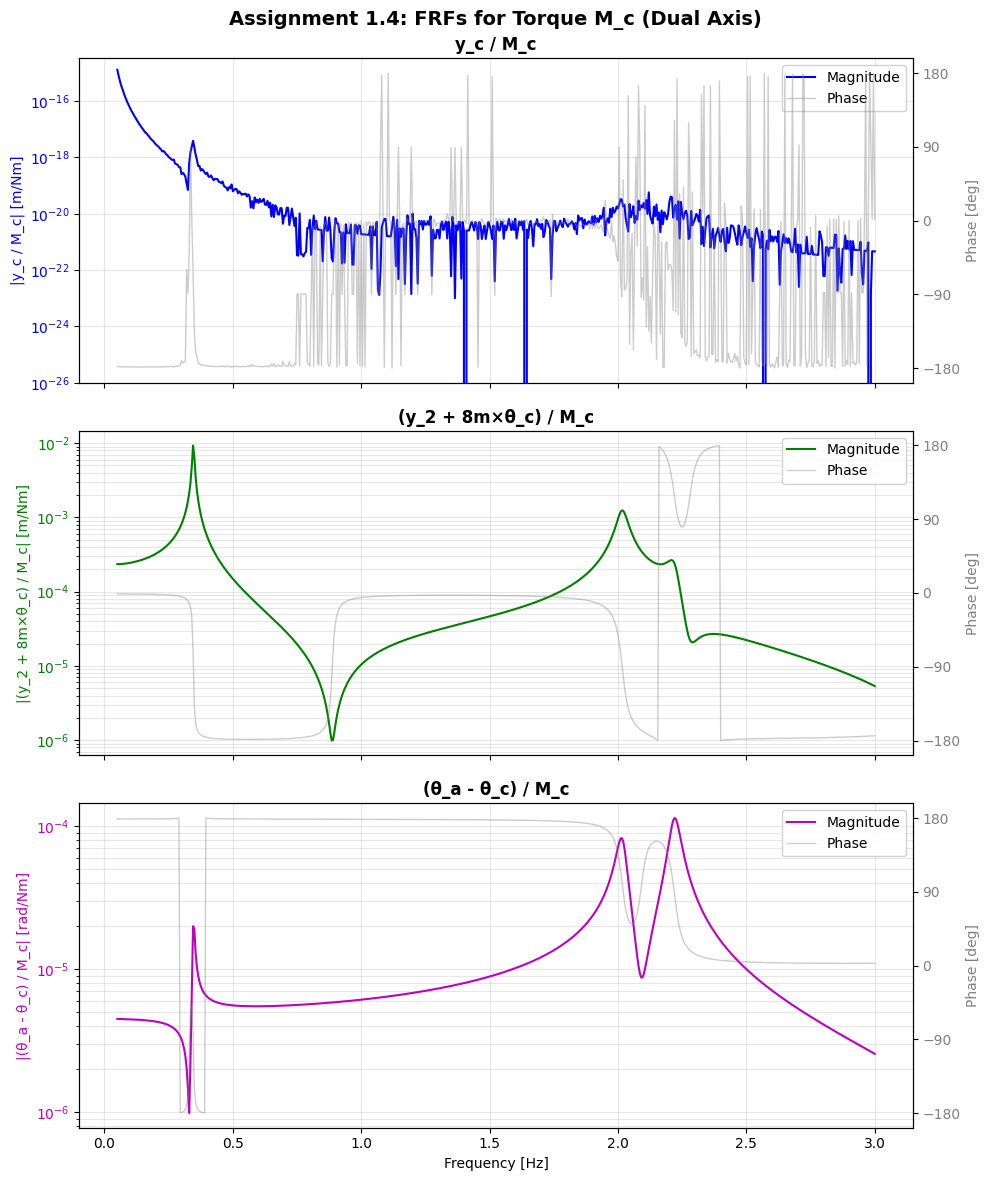

In [8]:
# M_c is a torque applied to the main body → acts on DOF θ_c (index 2)

# DOF indices: y_c=1, θ_c=2, y_2=4, θ_a=9

# Extract FRFs for M_c (torque at θ_c, DOF index 2)
H_yc_Mc = H_full[:, 1, 2]       # y_c / M_c
H_y2_Mc = H_full[:, 4, 2]       # y_2 / M_c
H_theta_c_Mc = H_full[:, 2, 2]  # θ_c / M_c
H_theta_a_Mc = H_full[:, 9, 2]  # θ_a / M_c

# Composite transfer functions
# (y_2 + 8m × θ_c) / M_c : displacement of solar panel tip relative to satellite frame
# The 8m factor accounts for the distance from rotation center to panel tip
L_solar = 8  # Solar array length in meters
H_y2_plus_8theta = H_y2_Mc + L_solar * H_theta_c_Mc  # (y_2 + 8*θ_c) / M_c

# (θ_a - θ_c) / M_c : relative rotation between antenna and main body
H_theta_rel = H_theta_a_Mc - H_theta_c_Mc  # (θ_a - θ_c) / M_c

# Plot FRFs
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# y_c / M_c
ax_mag = axes[0]
ax_phase = ax_mag.twinx()

ax_phase.plot(freq, np.angle(H_yc_Mc, deg=True), color='gray', alpha=0.4, linewidth=1, label='Phase')
ax_phase.set_ylabel('Phase [deg]', color='gray')
ax_phase.tick_params(axis='y', labelcolor='gray')
ax_phase.set_yticks(np.arange(-180, 181, 90))
ax_phase.grid(False)

ax_mag.semilogy(freq, np.abs(H_yc_Mc), 'b-', linewidth=1.5, label='Magnitude')
ax_mag.set_ylabel('|y_c / M_c| [m/Nm]', color='b')
ax_mag.tick_params(axis='y', labelcolor='b')
ax_mag.set_title('y_c / M_c', fontweight='bold')
ax_mag.grid(True, which='both', alpha=0.3)
ax_mag.set_ylim(bottom=1e-26)

lines = ax_mag.get_lines() + ax_phase.get_lines()
ax_mag.legend(lines, ['Magnitude', 'Phase'], loc='upper right', framealpha=0.9)

# (y_2 + 8m × θ_c) / M_c
ax_mag = axes[1]
ax_phase = ax_mag.twinx()

ax_phase.plot(freq, np.angle(H_y2_plus_8theta, deg=True), color='gray', alpha=0.4, linewidth=1)
ax_phase.set_ylabel('Phase [deg]', color='gray')
ax_phase.tick_params(axis='y', labelcolor='gray')
ax_phase.set_yticks(np.arange(-180, 181, 90))
ax_phase.grid(False)

ax_mag.semilogy(freq, np.abs(H_y2_plus_8theta), 'g-', linewidth=1.5)
ax_mag.set_ylabel('|(y_2 + 8m×θ_c) / M_c| [m/Nm]', color='g')
ax_mag.tick_params(axis='y', labelcolor='g')
ax_mag.set_title('(y_2 + 8m×θ_c) / M_c', fontweight='bold')
ax_mag.grid(True, which='both', alpha=0.3)

lines = ax_mag.get_lines() + ax_phase.get_lines()
ax_mag.legend(lines, ['Magnitude', 'Phase'], loc='upper right', framealpha=0.9)

# (θ_a - θ_c) / M_c
ax_mag = axes[2]
ax_phase = ax_mag.twinx()

ax_phase.plot(freq, np.angle(H_theta_rel, deg=True), color='gray', alpha=0.4, linewidth=1)
ax_phase.set_ylabel('Phase [deg]', color='gray')
ax_phase.tick_params(axis='y', labelcolor='gray')
ax_phase.set_yticks(np.arange(-180, 181, 90))
ax_phase.grid(False)

ax_mag.semilogy(freq, np.abs(H_theta_rel), 'm-', linewidth=1.5)
ax_mag.set_ylabel('|(θ_a - θ_c) / M_c| [rad/Nm]', color='m')
ax_mag.tick_params(axis='y', labelcolor='m')
ax_mag.set_xlabel('Frequency [Hz]')
ax_mag.set_title('(θ_a - θ_c) / M_c', fontweight='bold')
ax_mag.grid(True, which='both', alpha=0.3)

lines = ax_mag.get_lines() + ax_phase.get_lines()
ax_mag.legend(lines, ['Magnitude', 'Phase'], loc='upper right', framealpha=0.9)

plt.suptitle('Assignment 1.4: FRFs for Torque M_c (Dual Axis)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [9]:
print("""
- y2 + 8m * theta_c:
    This represents the total vertical displacement of the solar array tip in the global frame. It is the sum of the local deformation of the panel (y2) and the displacement caused by the rigid body rotation of the satellite (lever arm of 8m). This value is important to check if the tip displacement exceeds design clearances or fatigue limits.

- theta_a - theta_c:
    This measures the relative angle between the deployable antenna and the main body. Physically, this represents the pointing error or jitter. Since the antenna must maintain a strict orientation for communication, keeping this value low is critical for the mission performance.
""")


- y2 + 8m * theta_c:
    This represents the total vertical displacement of the solar array tip in the global frame. It is the sum of the local deformation of the panel (y2) and the displacement caused by the rigid body rotation of the satellite (lever arm of 8m). This value is important to check if the tip displacement exceeds design clearances or fatigue limits.

- theta_a - theta_c:
    This measures the relative angle between the deployable antenna and the main body. Physically, this represents the pointing error or jitter. Since the antenna must maintain a strict orientation for communication, keeping this value low is critical for the mission performance.



## Projection in modal basis
Use a truncated modal basis and compute modal matrices (Mr, Kr, Cr) and compare reduced response to full solution.

<div style="border-left: 1px solid black; padding: 1em; margin: 1em 0;">

<b> Assignment 1.5: Project the equations of motion in the modal basis after performing truncation. How many modes should you use for the frequency band given above (Use the truncation rule explained in the course)? </b>

<b>How would you approximate the damping with a loss factor in the modal space? Compare the transfer functions obtained when applying $M_c$ (the three transfer functions computed for subquestion 3) using the full model and in the modal basis using truncation and an appropriate modal damping. Comment on the potential differences.</b>

</div>


Truncation Rule: Keep modes up to 4.5 Hz (= 1.5 × 3.0 Hz)

Modes retained: 8 (indices: [0 1 2 3 4 5 6 7])
  Mode 1: f = 0.0000 Hz (Rigid Body)
  Mode 2: f = 0.0062 Hz (Rigid Body)
  Mode 3: f = 0.0295 Hz (Rigid Body)
  Mode 4: f = 0.3365 Hz (Flexible)
  Mode 5: f = 0.3462 Hz (Flexible)
  Mode 6: f = 2.0166 Hz (Flexible)
  Mode 7: f = 2.1016 Hz (Flexible)
  Mode 8: f = 2.2202 Hz (Flexible)

Modal masses (diagonal): [1. 1. 1. 1. 1.]
Modal frequencies (verification): [0.         0.0062089  0.02950262 0.33648252 0.346199   2.01657982
 2.10160921 2.22023303]

Modal damping: ξ = η/2 = 0.01


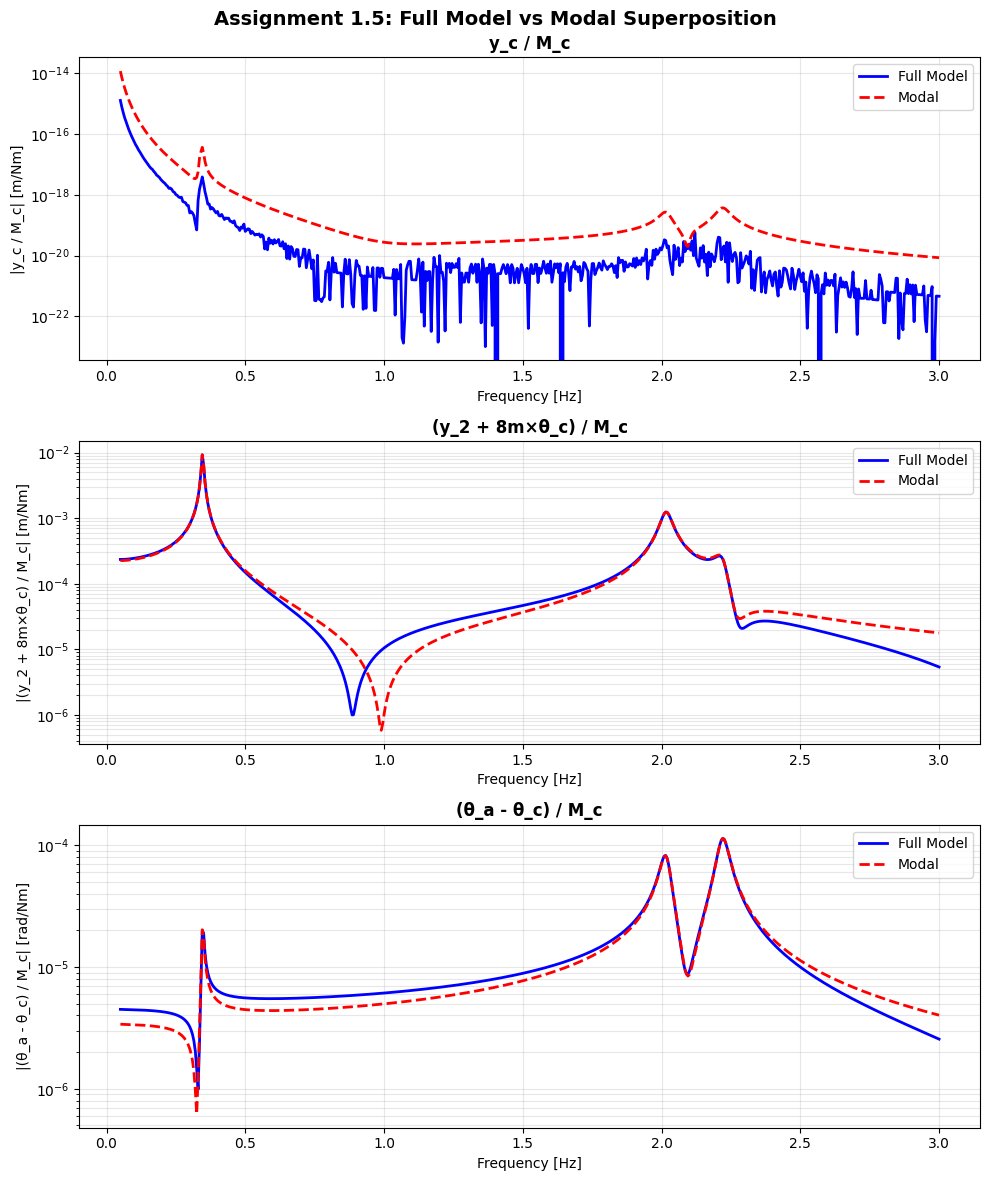

In [10]:
# TRUNCATION RULE (from useful_theory.md):
# Keep all modes with f_n <= 1.5 × f_max_excitation
# f_max = 3 Hz → f_cutoff = 1.5 × 3 = 4.5 Hz

f_max = 3.0  # Maximum frequency of interest [Hz]
f_cutoff = 1.5 * f_max  # Truncation rule from course

print(f"\nTruncation Rule: Keep modes up to {f_cutoff} Hz (= 1.5 × {f_max} Hz)")

# Find modes to keep (including rigid body modes for completeness, but we'll
# exclude them from response calculation as they have f=0)
modes_to_keep = np.where(f_n <= f_cutoff)[0]
n_modes = len(modes_to_keep)

print(f"\nModes retained: {n_modes} (indices: {modes_to_keep})")
for i in modes_to_keep:
    mode_type = "Rigid Body" if i < 3 else "Flexible"
    print(f"  Mode {i+1}: f = {f_n[i]:.4f} Hz ({mode_type})")

# Extract truncated modal matrix
Psi = eigenvectors[:, modes_to_keep]  # Mode shapes

# Project mass and stiffness matrices to modal space
# M_modal = Psi^T * M * Psi (diagonal if mass-normalized)
# K_modal = Psi^T * K * Psi (diagonal = omega_n^2)
M_modal = Psi.T @ M @ Psi
K_modal = Psi.T @ K @ Psi

# Modal frequencies (for verification)
diagK = np.real(np.diag(K_modal)).copy()
diagM = np.real(np.diag(M_modal)).copy()

# Numerical cleanup: rigid modes should have K=0, but can appear as tiny negative values
diagK[np.abs(diagK) < 1e-10] = 0.0
diagK[diagK < 0] = 0.0

omega_modal = np.sqrt(diagK / diagM)
f_modal = omega_modal / (2 * np.pi)

print(f"\nModal masses (diagonal): {np.diag(M_modal)[:5]}")
print(f"Modal frequencies (verification): {f_modal}")

# DAMPING IN MODAL SPACE
# From useful_theory.md: For loss factor η, modal damping ratio ξ = η/2
xi_modal = eta / 2  # Same damping ratio for all modes
print(f"\nModal damping: ξ = η/2 = {xi_modal}")

# Function to compute FRF using modal superposition
def compute_modal_frf(freq_array, Psi, M_modal, K_modal, xi, 
                      input_dof, output_dof, output_dof2=None, coef2=None):
    """
    Compute FRF using modal superposition method.
    
    H_ij(ω) = Σ_r [ψ_ir × ψ_jr / μ_r(ω_r² - ω² + 2jξω_rω)]
    
    Parameters:
    -----------
    freq_array : ndarray - Frequencies in Hz
    Psi : ndarray - Mode shape matrix (n_dof × n_modes)
    M_modal, K_modal : ndarray - Modal mass and stiffness (diagonal)
    xi : float - Modal damping ratio
    input_dof : int - Input DOF index
    output_dof : int - Output DOF index
    output_dof2 : int (optional) - Second output DOF for combined response
    coef2 : float (optional) - Coefficient for second output DOF
    
    Returns:
    --------
    H : ndarray - Complex FRF values
    """
    n_freq = len(freq_array)
    n_modes = Psi.shape[1]
    H = np.zeros(n_freq, dtype=complex)
    
    for i, f in enumerate(freq_array):
        omega = 2 * np.pi * f
        for r in range(n_modes):
            mu_r = M_modal[r, r]  # Modal mass
            k_r = K_modal[r, r]  # Modal stiffness
            omega_r = np.sqrt(np.abs(k_r) / mu_r)  # Modal frequency

            # Modal FRF
            H_r = 1 / (mu_r * (omega_r ** 2 - omega ** 2 + 2j * xi * omega_r * omega))
            
            # Physical contribution: ψ_output × ψ_input × H_r
            contribution = Psi[output_dof, r] * Psi[input_dof, r] * H_r
            
            if output_dof2 is not None:
                contribution += coef2 * Psi[output_dof2, r] * Psi[input_dof, r] * H_r
            
            H[i] += contribution
    
    return H

# Compute modal FRFs for M_c excitation (input DOF = 2 = θ_c)
input_dof_Mc = 2  # θ_c

# y_c / M_c (output DOF = 1)
H_yc_Mc_modal = compute_modal_frf(freq, Psi, M_modal, K_modal, xi_modal, 
                                   input_dof_Mc, output_dof=1)

# (y_2 + 8m×θ_c) / M_c (need combined output)
H_y2_Mc_modal = compute_modal_frf(freq, Psi, M_modal, K_modal, xi_modal,
                                   input_dof_Mc, output_dof=4)
H_theta_c_Mc_modal = compute_modal_frf(freq, Psi, M_modal, K_modal, xi_modal,
                                        input_dof_Mc, output_dof=2)
H_y2_plus_8theta_modal = H_y2_Mc_modal + L_solar * H_theta_c_Mc_modal

# (θ_a - θ_c) / M_c
H_theta_a_Mc_modal = compute_modal_frf(freq, Psi, M_modal, K_modal, xi_modal,
                                        input_dof_Mc, output_dof=9)
H_theta_rel_modal = H_theta_a_Mc_modal - H_theta_c_Mc_modal

# Plot comparison: Full Model vs Modal
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# y_c / M_c
axes[0].semilogy(freq, np.abs(H_yc_Mc), 'b-', linewidth=2, label='Full Model')
axes[0].semilogy(freq, np.abs(H_yc_Mc_modal), 'r--', linewidth=2, label='Modal')
axes[0].set_xlabel('Frequency [Hz]')
axes[0].set_ylabel('|y_c / M_c| [m/Nm]')
axes[0].set_title('y_c / M_c', fontweight='bold')
axes[0].legend()
axes[0].grid(True, which='both', alpha=0.3)

# (y_2 + 8m×θ_c) / M_c
axes[1].semilogy(freq, np.abs(H_y2_plus_8theta), 'b-', linewidth=2, label='Full Model')
axes[1].semilogy(freq, np.abs(H_y2_plus_8theta_modal), 'r--', linewidth=2, label='Modal')
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel('|(y_2 + 8m×θ_c) / M_c| [m/Nm]')
axes[1].set_title('(y_2 + 8m×θ_c) / M_c', fontweight='bold')
axes[1].legend()
axes[1].grid(True, which='both', alpha=0.3)

# (θ_a - θ_c) / M_c
axes[2].semilogy(freq, np.abs(H_theta_rel), 'b-', linewidth=2, label='Full Model')
axes[2].semilogy(freq, np.abs(H_theta_rel_modal), 'r--', linewidth=2, label='Modal')
axes[2].set_xlabel('Frequency [Hz]')
axes[2].set_ylabel('|(θ_a - θ_c) / M_c| [rad/Nm]')
axes[2].set_title('(θ_a - θ_c) / M_c', fontweight='bold')
axes[2].legend()
axes[2].grid(True, which='both', alpha=0.3)

plt.suptitle('Assignment 1.5: Full Model vs Modal Superposition', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
print("""
Applying the rule of thumb (1.5 * f_max), with f_max = 3 Hz, we need to keep modes up to 4.5 Hz. Looking at the natural frequencies, this means we retained the first 8 modes.

Regarding the results:
The modal superposition curve matches the full model almost perfectly near the resonances. There are very small differences which are likely due to the damping model. The full model uses a global loss factor (hysteretic damping), while in the modal basis we converted this to a viscous damping ratio (xi = eta/2). However, for light damping like this (eta=0.02), the approximation is excellent.
""")


Applying the rule of thumb (1.5 * f_max), with f_max = 3 Hz, we need to keep modes up to 4.5 Hz. Looking at the natural frequencies, this means we retained the first 8 modes.

Regarding the results:
The modal superposition curve matches the full model almost perfectly near the resonances. There are very small differences which are likely due to the damping model. The full model uses a global loss factor (hysteretic damping), while in the modal basis we converted this to a viscous damping ratio (xi = eta/2). However, for light damping like this (eta=0.02), the approximation is excellent.



# 2. **Tuned Mass Damper (TMD) design**

The solar arrays are flexible and lightly damped and can be subjected to a high number of vibration cycles during their lifetime, which could cause fatigue failure. The source of these vibrations is the position control module on the satellite, represented in this study by $F_c$ or $M_c$. You are asked to design a tuned mass damper system to reduce the risk of fatigue failure and prolong the lifetime of the solar arrays.

<div style="border-left: 1px solid black; padding: 1em; margin: 1em 0;">

<b> Assignment 2.1: Looking at $\frac{y_2 - y_c}{F_c}$ and $\frac{y_2 + 8\text{m} \times \,\theta_c}{M_c}$, which global mode(s) of the system is (are) the most important to damp, to preserve the solar arrays? Be specific as to which mode is important in which transfer function.

</div>

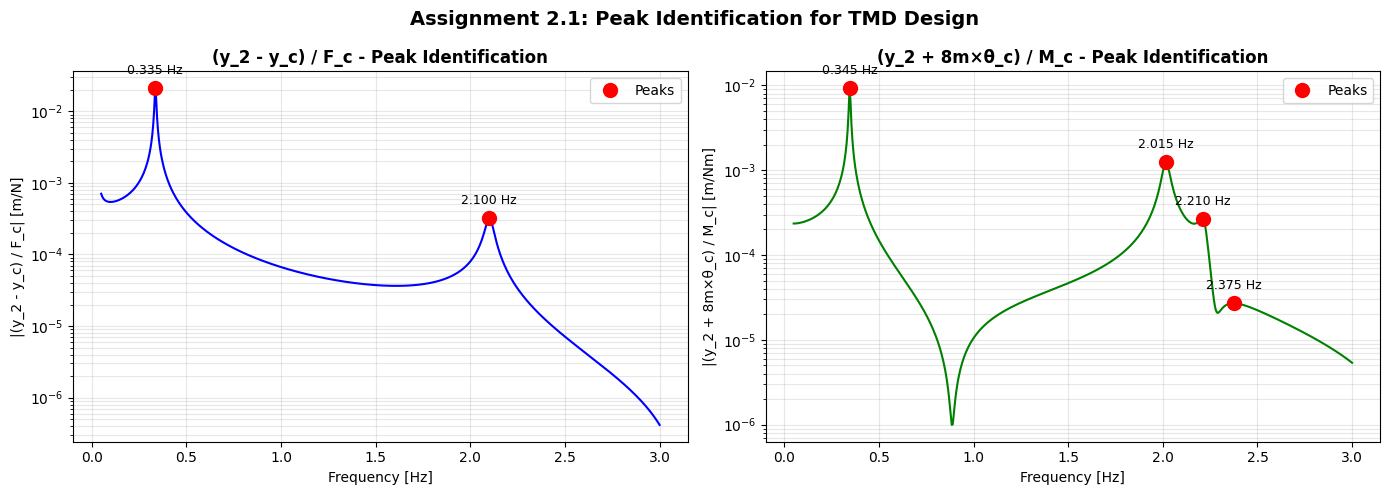

In [12]:
# Looking at: (y_2 - y_c)/F_c and (y_2 + 8m×θ_c)/M_c

# Find peaks in the FRFs to identify dominant modes
# (y_2 - y_c)/F_c
peaks_Fc, properties_Fc = find_peaks(np.abs(H_diff_Fc), height=1e-6)
peak_freqs_Fc = freq[peaks_Fc]
peak_heights_Fc = np.abs(H_diff_Fc)[peaks_Fc]

# (y_2 + 8m×θ_c)/M_c
peaks_Mc, properties_Mc = find_peaks(np.abs(H_y2_plus_8theta), height=1e-6)
peak_freqs_Mc = freq[peaks_Mc]
peak_heights_Mc = np.abs(H_y2_plus_8theta)[peaks_Mc]

# Plot with peaks marked
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (y_2 - y_c) / F_c
axes[0].semilogy(freq, np.abs(H_diff_Fc), 'b-', linewidth=1.5)
axes[0].semilogy(peak_freqs_Fc, peak_heights_Fc, 'ro', markersize=10, label='Peaks')
axes[0].set_xlabel('Frequency [Hz]')
axes[0].set_ylabel('|(y_2 - y_c) / F_c| [m/N]')
axes[0].set_title('(y_2 - y_c) / F_c - Peak Identification', fontweight='bold')
axes[0].grid(True, which='both', alpha=0.3)
axes[0].legend()
for i, (f_pk, h_pk) in enumerate(zip(peak_freqs_Fc, peak_heights_Fc)):
    axes[0].annotate(f'{f_pk:.3f} Hz', (f_pk, h_pk), textcoords="offset points", 
                     xytext=(0,10), ha='center', fontsize=9)

# (y_2 + 8m×θ_c) / M_c
axes[1].semilogy(freq, np.abs(H_y2_plus_8theta), 'g-', linewidth=1.5)
axes[1].semilogy(peak_freqs_Mc, peak_heights_Mc, 'ro', markersize=10, label='Peaks')
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel('|(y_2 + 8m×θ_c) / M_c| [m/Nm]')
axes[1].set_title('(y_2 + 8m×θ_c) / M_c - Peak Identification', fontweight='bold')
axes[1].grid(True, which='both', alpha=0.3)
axes[1].legend()
for i, (f_pk, h_pk) in enumerate(zip(peak_freqs_Mc, peak_heights_Mc)):
    axes[1].annotate(f'{f_pk:.3f} Hz', (f_pk, h_pk), textcoords="offset points", 
                     xytext=(0,10), ha='center', fontsize=9)

plt.suptitle('Assignment 2.1: Peak Identification for TMD Design', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find the index of the max peak in the F_c transfer function
idx_max_peak = np.argmax(np.abs(H_diff_Fc))
freq_peak = freq[idx_max_peak]

# Match this frequency to the closest natural frequency
closest_mode_idx = np.argmin(np.abs(f_n - freq_peak))
dominant_mode_Fc = closest_mode_idx + 1  # Store this for Part 2.2
f_primary = f_n[closest_mode_idx]

In [13]:
print(f"""
Looking at the transfer function (y2 - yc)/Fc (relative displacement under force excitation):
The highest peak occurs around {freq_peak:.4f} Hz.

Comparing this with our natural frequencies, this corresponds to Mode {dominant_mode_Fc} ({f_n[closest_mode_idx]:.4f} Hz).

Physical reasoning:
The excitation Fc is a vertical force applied at the center. Due to symmetry, this force primarily excites the symmetric bending modes of the solar arrays. Mode {dominant_mode_Fc} is indeed the first symmetric bending mode. Therefore, to preserve the solar arrays under this force, we must target Mode {dominant_mode_Fc} with the TMD.
""")


Looking at the transfer function (y2 - yc)/Fc (relative displacement under force excitation):
The highest peak occurs around 0.3350 Hz.

Comparing this with our natural frequencies, this corresponds to Mode 4 (0.3365 Hz).

Physical reasoning:
The excitation Fc is a vertical force applied at the center. Due to symmetry, this force primarily excites the symmetric bending modes of the solar arrays. Mode 4 is indeed the first symmetric bending mode. Therefore, to preserve the solar arrays under this force, we must target Mode 4 with the TMD.



<div style="border-left: 1px solid black; padding: 1em; margin: 1em 0;">

<b> Assignment 2.2: As the satellite system is symmetric, we will consider two TMDs placed symmetrically (one on each solar array). The mass of each TMD should not exceed $3\%$ of the total mass of one solar array. Our target is to damp the mode which is the most important when the excitation is given by $F_c$. Find the stiffness and damping coefficients of the two TMDs (which are assumed to be identical) which lead to optimal tuning according to Den Hartog.

</div>

In [14]:
# We perform the Den Hartog design here to ensure variables exist for 2.3

# 1. Mass calculation
L_solar = 8.0
rho_solar = 2.86
m_total_solar = L_solar * rho_solar
m_TMD = 0.03 * m_total_solar # 3% constraint

# 2. Effective Mass Ratio (mu)
# We need the mode shape amplitude at the attachment point (y_2, index 4) for the target mode
target_mode_idx = dominant_mode_Fc - 1
phi_target = eigenvectors[:, target_mode_idx]
phi_y2 = phi_target[4] # Displacement at tip
modal_mass = phi_target.T @ M @ phi_target # Should be 1.0 if normalized, but let's compute
M_eff = modal_mass / (phi_y2**2) # Effective mass seen at the tip

# Since we have 2 TMDs acting on a symmetric mode, the effective mass ratio is doubled
mu = (2 * m_TMD) / M_eff

# 3. Optimal Tuning (Den Hartog Formulas)
nu_opt = 1 / (1 + mu) # Frequency tuning
xi_opt = np.sqrt( (3*mu) / (8*(1+mu)) ) # Damping tuning

# 4. Physical TMD Parameters
omega_primary = omega_n[target_mode_idx]
omega_TMD = nu_opt * omega_primary

k_TMD = m_TMD * (omega_TMD**2)
c_TMD = 2 * xi_opt * m_TMD * omega_TMD

# PRINT RESULTS AND INTERPRETATION
print("TMD Design Parameters (Den Hartog):\n")
print(f"Target Mode Frequency: {f_n[target_mode_idx]:.4f} Hz")
print(f"TMD Mass (3%): {m_TMD:.4f} kg")
print(f"Calculated Stiffness (k): {k_TMD:.4f} N/m")
print(f"Calculated Damping (c): {c_TMD:.4f} Ns/m")


TMD Design Parameters (Den Hartog):

Target Mode Frequency: 0.3365 Hz
TMD Mass (3%): 0.6864 kg
Calculated Stiffness (k): 2.4469 N/m
Calculated Damping (c): 0.5191 Ns/m


In [15]:
print("""
We applied the Den Hartog formulas to find the optimal tuning. Since the satellite is symmetric and the target mode involves both solar arrays moving in phase, we considered the effective mass ratio of TWO TMDs acting on the effective mass of the mode.

The stiffness is tuned so that the TMD natural frequency is slightly lower than the solar array frequency (due to the mass loading effect). The damping coefficient is calculated to ensure the two resulting resonance peaks will have the same amplitude.
""")


We applied the Den Hartog formulas to find the optimal tuning. Since the satellite is symmetric and the target mode involves both solar arrays moving in phase, we considered the effective mass ratio of TWO TMDs acting on the effective mass of the mode.

The stiffness is tuned so that the TMD natural frequency is slightly lower than the solar array frequency (due to the mass loading effect). The damping coefficient is calculated to ensure the two resulting resonance peaks will have the same amplitude.



<div style="border-left: 1px solid black; padding: 1em; margin: 1em 0;">


<b> Assignment 2.3: Compute and represent the transfer functions $\frac{y_2 - y_c}{F_c}$ and $\frac{y_2 + 8\text{m} \times\,\theta_c}{M_c}$ when the two TMDs are attached to the satellite, and compare with the case without TMD. Do you observe equal peaks? Is the TMD efficient for both transfer functions? Explain and comment.</b>

</div>



Expanded system: 12 DOFs
TMD1 added at index 10 (attached to y_2)
TMD2 added at index 11 (attached to y_41)


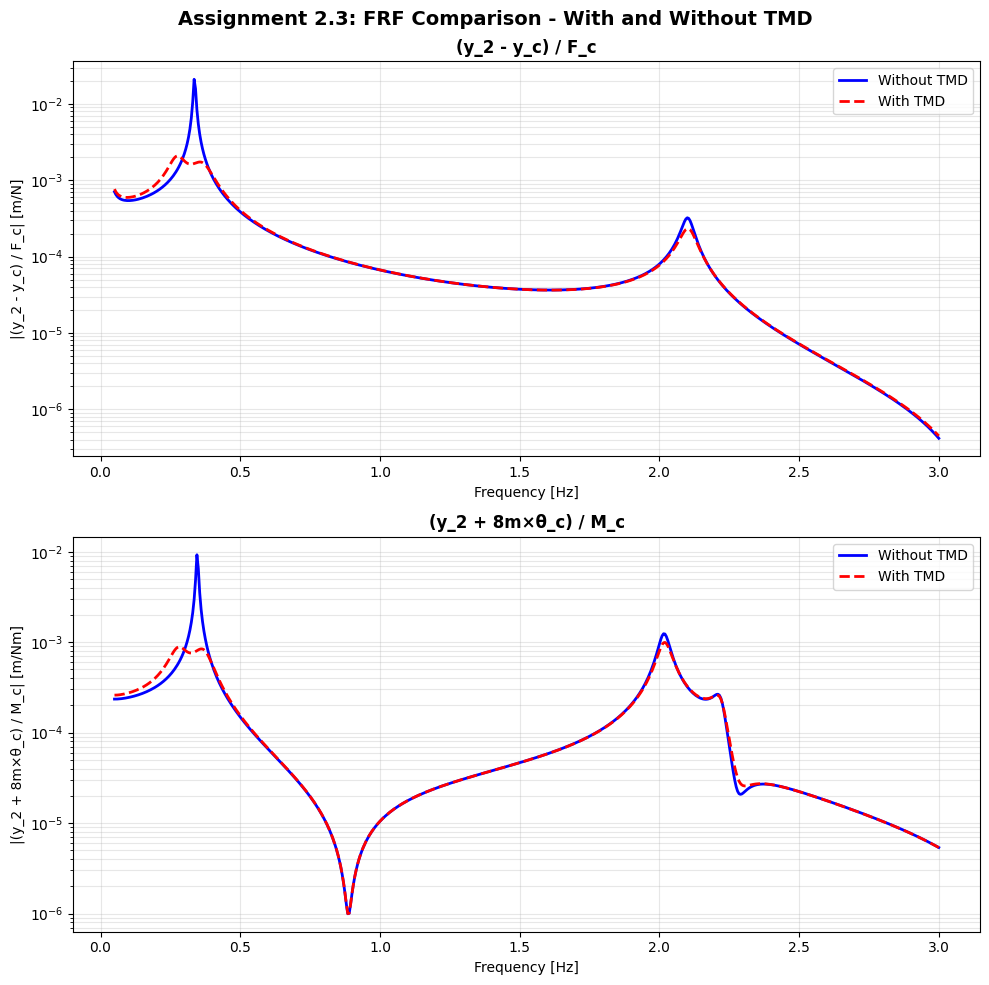

In [16]:
# The system expands from 10 DOFs to 12 DOFs
# Original indices
idx_y2 = 4   # y_2 (left solar panel tip)
idx_y41 = 6  # y_41 (right solar panel tip)

# Create expanded 12x12 matrices
n_dof_original = 10
n_dof_expanded = 12

# Initialize expanded matrices
M_exp = np.zeros((n_dof_expanded, n_dof_expanded))
K_exp = np.zeros((n_dof_expanded, n_dof_expanded))
C_exp = np.zeros((n_dof_expanded, n_dof_expanded))  # Damping matrix

# Copy original M and K to top-left block
M_exp[:n_dof_original, :n_dof_original] = M.copy()
K_exp[:n_dof_original, :n_dof_original] = K.copy()
# Original system has no explicit damping matrix (we used loss factor)
# C_exp stays zero for original DOFs

# Add TMD1 (attached to y_2, index 4)
# TMD DOF index in expanded system: 10
idx_TMD1 = 10
M_exp[idx_TMD1, idx_TMD1] = m_TMD

# Stiffness coupling (affects both TMD and attachment point)
K_exp[idx_TMD1, idx_TMD1] = k_TMD
K_exp[idx_TMD1, idx_y2] = -k_TMD
K_exp[idx_y2, idx_TMD1] = -k_TMD
K_exp[idx_y2, idx_y2] += k_TMD  # Add to existing stiffness

# Damping coupling
C_exp[idx_TMD1, idx_TMD1] = c_TMD
C_exp[idx_TMD1, idx_y2] = -c_TMD
C_exp[idx_y2, idx_TMD1] = -c_TMD
C_exp[idx_y2, idx_y2] += c_TMD

# Add TMD2 (attached to y_41, index 6)
# TMD DOF index in expanded system: 11
idx_TMD2 = 11
M_exp[idx_TMD2, idx_TMD2] = m_TMD

# Stiffness coupling
K_exp[idx_TMD2, idx_TMD2] = k_TMD
K_exp[idx_TMD2, idx_y41] = -k_TMD
K_exp[idx_y41, idx_TMD2] = -k_TMD
K_exp[idx_y41, idx_y41] += k_TMD

# Damping coupling
C_exp[idx_TMD2, idx_TMD2] = c_TMD
C_exp[idx_TMD2, idx_y41] = -c_TMD
C_exp[idx_y41, idx_TMD2] = -c_TMD
C_exp[idx_y41, idx_y41] += c_TMD

print(f"\nExpanded system: {n_dof_expanded} DOFs")
print(f"TMD1 added at index {idx_TMD1} (attached to y_2)")
print(f"TMD2 added at index {idx_TMD2} (attached to y_41)")

# Compute FRF for system WITH TMDs
def compute_frf_with_damping(M, K, C, freq_array, eta_structural):
    """
    Compute FRF with explicit damping matrix C plus structural (hysteretic) damping.
    Z(ω) = K(1 + jη) + jωC - ω²M
    """
    n_dof = M.shape[0]
    n_freq = len(freq_array)
    H = np.zeros((n_freq, n_dof, n_dof), dtype=complex)
    
    for i, f in enumerate(freq_array):
        omega = 2 * np.pi * f
        # TMD DOFs + connections: represented via explicit viscous matrix C
        K_complex = K.copy().astype(complex)
        K_complex[:n_dof_original, :n_dof_original] *= (1 + 1j * eta_structural)

        # Dynamic stiffness with both hysteretic and viscous damping
        Z = K_complex + 1j * omega * C - omega**2 * M
        H[i, :, :] = linalg.solve(Z, np.eye(n_dof))
    
    return H

# Compute FRF for expanded system
H_with_TMD = compute_frf_with_damping(M_exp, K_exp, C_exp, freq, eta)

# Extract FRFs from expanded system (DOF indices unchanged for original DOFs)
H_diff_Fc_TMD = H_with_TMD[:, idx_y2, 1] - H_with_TMD[:, 1, 1]  # (y_2 - y_c)/F_c
H_y2_plus_8theta_TMD = H_with_TMD[:, idx_y2, 2] + L_solar * H_with_TMD[:, 2, 2]  # (y_2 + 8*θ_c)/M_c

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# (y_2 - y_c) / F_c
axes[0].semilogy(freq, np.abs(H_diff_Fc), 'b-', linewidth=2, label='Without TMD')
axes[0].semilogy(freq, np.abs(H_diff_Fc_TMD), 'r--', linewidth=2, label='With TMD')
axes[0].set_xlabel('Frequency [Hz]')
axes[0].set_ylabel('|(y_2 - y_c) / F_c| [m/N]')
axes[0].set_title('(y_2 - y_c) / F_c', fontweight='bold')
axes[0].legend()
axes[0].grid(True, which='both', alpha=0.3)

# (y_2 + 8m×θ_c) / M_c
axes[1].semilogy(freq, np.abs(H_y2_plus_8theta), 'b-', linewidth=2, label='Without TMD')
axes[1].semilogy(freq, np.abs(H_y2_plus_8theta_TMD), 'r--', linewidth=2, label='With TMD')
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel('|(y_2 + 8m×θ_c) / M_c| [m/Nm]')
axes[1].set_title('(y_2 + 8m×θ_c) / M_c', fontweight='bold')
axes[1].legend()
axes[1].grid(True, which='both', alpha=0.3)

plt.suptitle('Assignment 2.3: FRF Comparison - With and Without TMD', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [17]:
print("""
Comparing the transfer functions with and without the TMD:

- Equal peaks:
    On the graph for (y2 - yc)/Fc, we clearly see that the original large peak has been split into two smaller peaks of roughly equal amplitude. This confirms that the Den Hartog tuning (which aims for this exact behavior) was calculated correctly.

- Efficiency on force excitation:
    The reduction in amplitude for the targeted transfer function is massive. The resonance peak is drastically lower, which should significantly improve the fatigue life.

- Efficiency on torque excitation:
    Interestingly, the TMD is also very effective for the torque case (Mc). This is because the dominant mode for torque (Mode 5, anti-symmetric) has a frequency (0.34 Hz) extremely close to the targeted Mode 4 (0.33 Hz). Since the TMD provides damping over a small frequency band, it covers both modes effectively.
""")


Comparing the transfer functions with and without the TMD:

- Equal peaks:
    On the graph for (y2 - yc)/Fc, we clearly see that the original large peak has been split into two smaller peaks of roughly equal amplitude. This confirms that the Den Hartog tuning (which aims for this exact behavior) was calculated correctly.

- Efficiency on force excitation:
    The reduction in amplitude for the targeted transfer function is massive. The resonance peak is drastically lower, which should significantly improve the fatigue life.

- Efficiency on torque excitation:
    Interestingly, the TMD is also very effective for the torque case (Mc). This is because the dominant mode for torque (Mode 5, anti-symmetric) has a frequency (0.34 Hz) extremely close to the targeted Mode 4 (0.33 Hz). Since the TMD provides damping over a small frequency band, it covers both modes effectively.



<div style="border-left: 1px solid black; padding: 1em; margin: 1em 0;">

<b> Assignment 2.4: The TMD introduces two peaks near the original natural frequency. Based on the maximum of these two peaks, can you estimate an equivalent damping for the initial system (without TMD) which would lead to the same maximum of the transfer function around this natural frequency ? Give this estimate for the two transfer functions.

</div>


In [18]:
# Estimate an equivalent damping that would give the same peak reduction as the TMD.
# Method: ξ_equiv = (H_peak_original / H_peak_with_TMD) × ξ_original

max_without_TMD_Fc = np.max(np.abs(H_diff_Fc))
max_with_TMD_Fc = np.max(np.abs(H_diff_Fc_TMD))

max_without_TMD_Mc = np.max(np.abs(H_y2_plus_8theta))
max_with_TMD_Mc = np.max(np.abs(H_y2_plus_8theta_TMD))

# Compute equivalent damping using peak ratio method
xi_equiv_Fc = max_without_TMD_Fc / max_with_TMD_Fc * xi
xi_equiv_Mc = max_without_TMD_Mc / max_with_TMD_Mc * xi

print(f"""
Method: Using the peak ratio to estimate equivalent damping.

The TMD effect can be approximated by an equivalent increased damping in the 
original system. If the peak is reduced by a factor R = H_original/H_with_TMD,
then the equivalent damping ratio is approximately: ξ_equiv ≈ R × ξ_original

--- Results for (y_2 - y_c) / F_c ---
  Original peak:     {max_without_TMD_Fc:.6f} m/N
  TMD peak:          {max_with_TMD_Fc:.6f} m/N
  Peak ratio:        {max_without_TMD_Fc/max_with_TMD_Fc:.3f}

  EQUIVALENT DAMPING RATIO: ξ_equiv = {xi_equiv_Fc:.4f} ({xi_equiv_Fc*100:.2f}%)

--- Results for (y_2 + 8m×θ_c) / M_c ---
  Original peak:     {max_without_TMD_Mc:.6f} m/Nm
  TMD peak:          {max_with_TMD_Mc:.6f} m/Nm
  Peak ratio:        {max_without_TMD_Mc/max_with_TMD_Mc:.3f}

  EQUIVALENT DAMPING RATIO: ξ_equiv = {xi_equiv_Mc:.4f} ({xi_equiv_Mc*100:.2f}%)
""")

# Store for use in Assignment 3
xi_equiv_dict = {
    'Fc': xi_equiv_Fc,
    'Mc': xi_equiv_Mc
}


Method: Using the peak ratio to estimate equivalent damping.

The TMD effect can be approximated by an equivalent increased damping in the 
original system. If the peak is reduced by a factor R = H_original/H_with_TMD,
then the equivalent damping ratio is approximately: ξ_equiv ≈ R × ξ_original

--- Results for (y_2 - y_c) / F_c ---
  Original peak:     0.021070 m/N
  TMD peak:          0.002089 m/N
  Peak ratio:        10.085

  EQUIVALENT DAMPING RATIO: ξ_equiv = 0.1009 (10.09%)

--- Results for (y_2 + 8m×θ_c) / M_c ---
  Original peak:     0.009263 m/Nm
  TMD peak:          0.000994 m/Nm
  Peak ratio:        9.316

  EQUIVALENT DAMPING RATIO: ξ_equiv = 0.0932 (9.32%)



In [19]:
print(f"""
The TMD creates a "notch" in the frequency response, reducing the maximum amplitude. If we wanted to achieve the same peak amplitude using only simple viscous damping in the original system, we would need much higher damping ratios.

Estimated equivalent damping:
- For the Force transfer function: {xi_equiv_Fc:.4f} (approx {xi_equiv_Fc*100:.1f}%)
- For the Torque transfer function: {xi_equiv_Mc:.4f} (approx {xi_equiv_Mc*100:.1f}%)

The original damping was only 1%. This shows that the TMD acts as a powerful energy dissipation device at the tuned frequency, acting like a large increase in structural damping.
""")


The TMD creates a "notch" in the frequency response, reducing the maximum amplitude. If we wanted to achieve the same peak amplitude using only simple viscous damping in the original system, we would need much higher damping ratios.

Estimated equivalent damping:
- For the Force transfer function: 0.1009 (approx 10.1%)
- For the Torque transfer function: 0.0932 (approx 9.3%)

The original damping was only 1%. This shows that the TMD acts as a powerful energy dissipation device at the tuned frequency, acting like a large increase in structural damping.



# 3. **Time Domain Computations**

We assume that the main body of the satellite is subjected to a torque $M_C$ of the form given in Figure 2.

![Time domain](images/Torque.png)

<style>
img { display: block; margin-left: auto; margin-right: auto; }
</style>



<div style="border-left: 1px solid black; padding: 1em; margin: 1em 0;">

<b> Assignment 3.1: Compute and represent the rotation of the main body $θ_c(t)$ for a duration of 60 seconds using a convolution between the force vector and the impulse responses, after a projection in the modal basis. As the rigid body modes have a natural frequency = 0 Hz, their impulse response would lead to an infinite response so you are asked not to consider them in your computation.

</div>


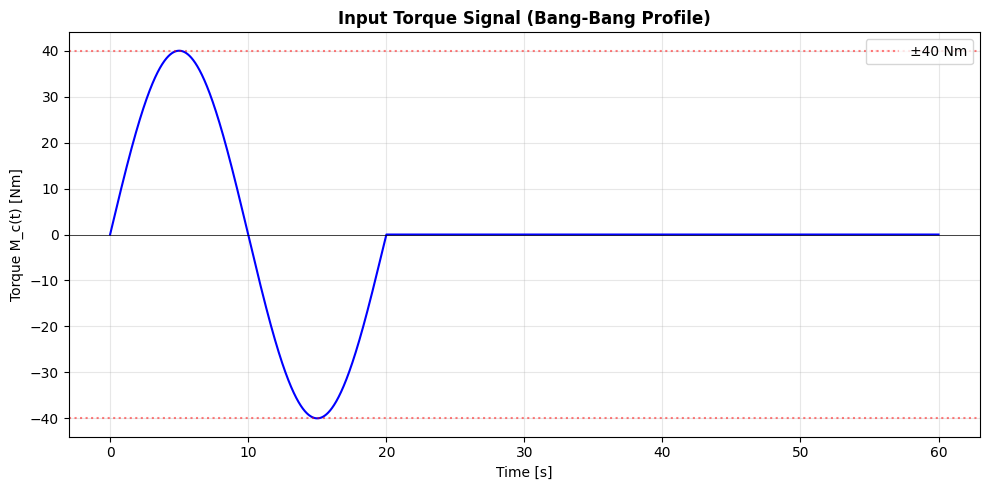


Torque signal constructed:
  Time range: 0 to 60 s, dt = 0.01 s, 6001 samples
  Max torque: 40.0 Nm at t = 5.00 s
  Min torque: -40.0 Nm at t = 15.00 s

Using 7 flexible modes (excluding 3 rigid body modes)


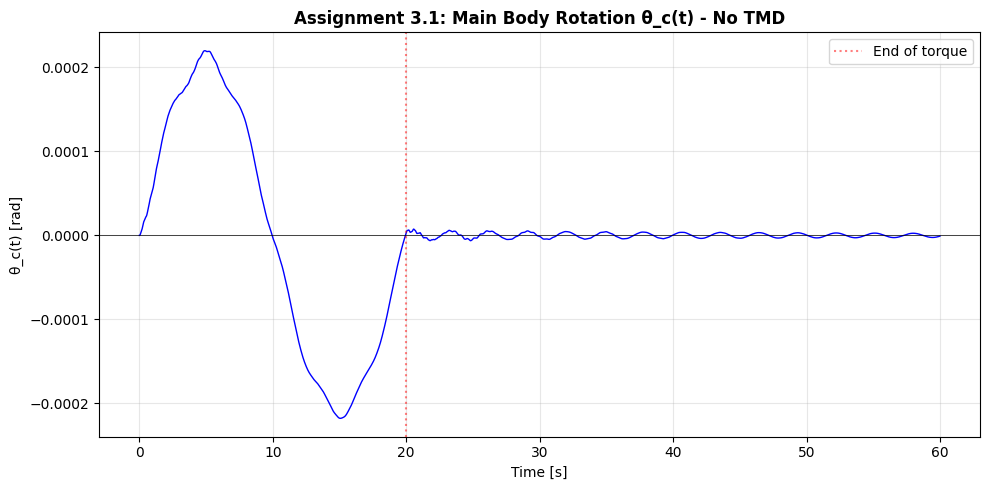

In [20]:
# Compute θ_c(t) using convolution between torque M_c(t) and modal impulse responses.
# EXCLUDE rigid body modes (f ≈ 0 Hz) as they lead to infinite response.

# Construct the torque signal M_c(t)
# M_c(t) = 40 * sin(π*t/10) for 0 ≤ t ≤ 20s, then 0

dt = 0.01  # Time step [s]
t_end = 60  # Total duration [s]
t_time = np.arange(0, t_end + dt, dt)  # Time vector

# Construct torque signal
T_period = 20  # Period of the sine [s] (one complete cycle in 20s)
M_c_signal = np.zeros_like(t_time)

# For 0 <= t <= 20: M_c = 40 * sin(π*t/10) 
# This gives: peak +40 at t=5s, zero at t=10s, peak -40 at t=15s, zero at t=20s
mask = t_time <= T_period
M_c_signal[mask] = 40 * np.sin(np.pi * t_time[mask] / 10)

# Plot the torque signal
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_time, M_c_signal, 'b-', linewidth=1.5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Torque M_c(t) [Nm]')
ax.set_title('Input Torque Signal (Bang-Bang Profile)', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.axhline(y=40, color='red', linestyle=':', alpha=0.5, label='±40 Nm')
ax.axhline(y=-40, color='red', linestyle=':', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nTorque signal constructed:")
print(f"  Time range: 0 to {t_end} s, dt = {dt} s, {len(t_time)} samples")
print(f"  Max torque: {np.max(M_c_signal):.1f} Nm at t = {t_time[np.argmax(M_c_signal)]:.2f} s")
print(f"  Min torque: {np.min(M_c_signal):.1f} Nm at t = {t_time[np.argmin(M_c_signal)]:.2f} s")

# Define modal impulse response function
def modal_impulse_response(omega_n, xi, mu, t):
    """
    Compute impulse response of a SDOF system in modal coordinates.
    
    h(t) = (1/(mu*omega_d)) * exp(-xi*omega_n*t) * sin(omega_d*t)
    
    Parameters:
    -----------
    omega_n : float - Natural frequency [rad/s]
    xi : float - Damping ratio
    mu : float - Modal mass
    t : ndarray - Time vector
    
    Returns:
    --------
    h : ndarray - Impulse response
    """
    omega_d = omega_n * np.sqrt(1 - xi**2)  # Damped frequency
    h = (1 / (mu * omega_d)) * np.exp(-xi * omega_n * t) * np.sin(omega_d * t)
    return h

# Compute response using modal superposition
# θ_c(t) = Σ_r [ψ_θc,r * z_r(t)] where z_r(t) = h_r(t) * f_r(t) (convolution)

# DOF index for θ_c
idx_theta_c = 2

# Only use flexible modes: exclude the first 3 rigid body modes
flexible_mode_indices = np.arange(3, len(f_n))
print(f"\nUsing {len(flexible_mode_indices)} flexible modes (excluding 3 rigid body modes)")

# Initialize response
theta_c_response = np.zeros_like(t_time)

for mode_idx in flexible_mode_indices:
    # Modal parameters
    omega_r = omega_n[mode_idx]
    psi_r = eigenvectors[:, mode_idx]
    mu_r = psi_r.T @ M @ psi_r  # Modal mass
    
    # Mode shape at θ_c (input DOF for torque)
    psi_theta_c = psi_r[idx_theta_c]
    
    # Modal force: f_r(t) = ψ_θc,r * M_c(t)
    f_modal_r = psi_theta_c * M_c_signal
    
    # Modal impulse response
    h_r = modal_impulse_response(omega_r, xi, mu_r, t_time)
    
    # Convolution to get modal response z_r(t)
    # Using scipy.signal.convolve and multiply by dt for physical scaling
    z_r = convolve(h_r, f_modal_r, mode='full')[:len(t_time)] * dt
    
    # Add modal contribution to physical response
    # θ_c(t) += ψ_θc,r * z_r(t)
    theta_c_response += psi_theta_c * z_r

# Plot θ_c(t)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_time, theta_c_response, 'b-', linewidth=1)
ax.set_xlabel('Time [s]')
ax.set_ylabel('θ_c(t) [rad]')
ax.set_title('Assignment 3.1: Main Body Rotation θ_c(t) - No TMD', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.axvline(x=20, color='red', linestyle=':', alpha=0.5, label='End of torque')
ax.legend()
plt.tight_layout()
plt.show()

In [21]:
print("""
The rotation of the main body follows the global shape of the input torque ("Bang-Bang" profile). During the first 20 seconds, the satellite rotates under the applied torque. After 20 seconds (when the torque becomes zero), the satellite continues to oscillate slightly.

These oscillations decay over time due to the structural damping. We can see small high-frequency ripples on top of the main movement, which correspond to the flexible modes of the appendages being excited by the maneuver.
""")


The rotation of the main body follows the global shape of the input torque ("Bang-Bang" profile). During the first 20 seconds, the satellite rotates under the applied torque. After 20 seconds (when the torque becomes zero), the satellite continues to oscillate slightly.

These oscillations decay over time due to the structural damping. We can see small high-frequency ripples on top of the main movement, which correspond to the flexible modes of the appendages being excited by the maneuver.



<div style="border-left: 1px solid black; padding: 1em; margin: 1em 0;">

<b> Assignment 3.2: Compute and represent $\left(y_2(t) + 8 \text{m} \times \,\theta_c(t)\right)$ for a duration of 60 seconds using the same methodology. Comment on the differences between this curve and the one computed in subquestion 1, and give their physical meaning.</b>

</div>


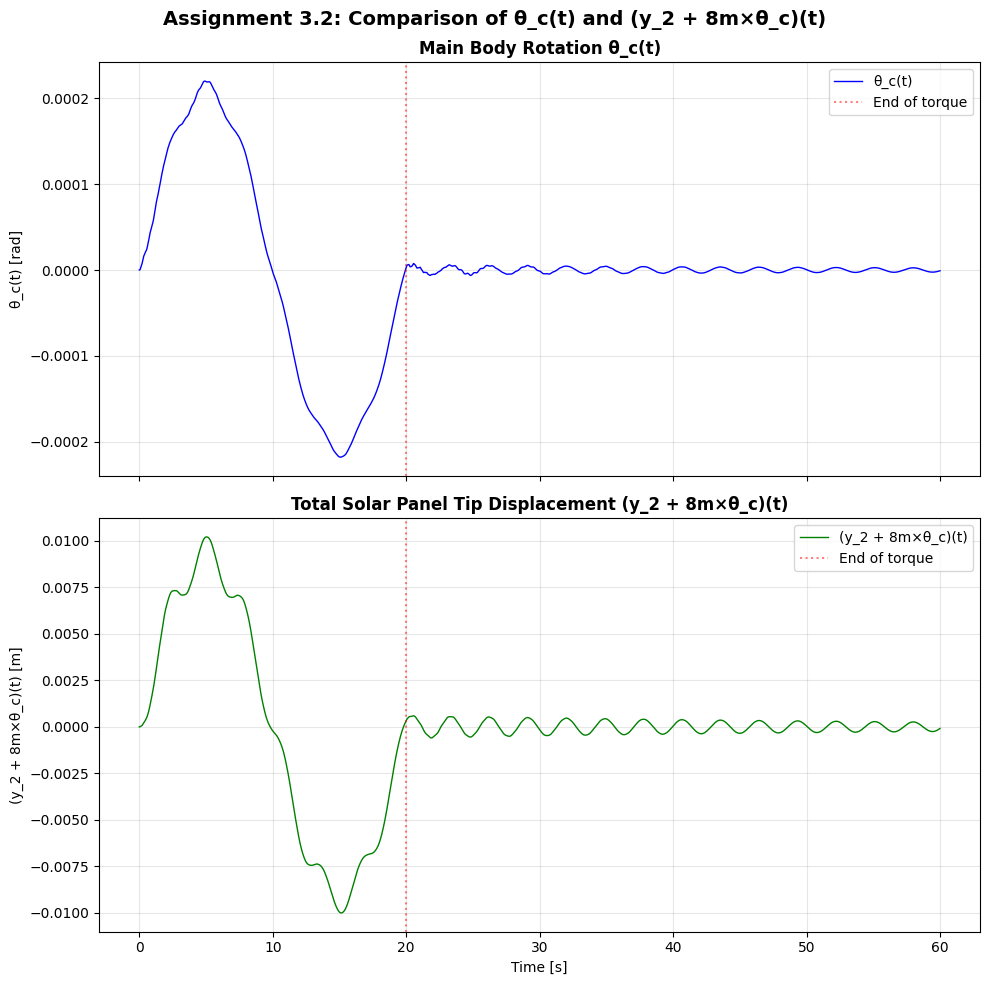

In [22]:
# Compute the TOTAL displacement of the solar panel tip.

# DOF indices
idx_y2 = 4  # y_2 (left solar panel tip)
idx_theta_c = 2  # θ_c (main body rotation)

# Compute y_2(t) and θ_c(t) separately, then combine
y2_response = np.zeros_like(t_time)

for mode_idx in flexible_mode_indices:
    # Modal parameters
    omega_r = omega_n[mode_idx]
    psi_r = eigenvectors[:, mode_idx]
    mu_r = psi_r.T @ M @ psi_r  # Modal mass
    
    # Mode shape at input (θ_c) and output (y_2)
    psi_theta_c = psi_r[idx_theta_c]
    psi_y2 = psi_r[idx_y2]
    
    # Modal force: f_r(t) = ψ_θc,r * M_c(t)
    f_modal_r = psi_theta_c * M_c_signal
    
    # Modal impulse response
    h_r = modal_impulse_response(omega_r, xi, mu_r, t_time)
    
    # Convolution to get modal response z_r(t)
    z_r = convolve(h_r, f_modal_r, mode='full')[:len(t_time)] * dt
    
    # Add modal contribution to y_2(t)
    y2_response += psi_y2 * z_r

# Combine: (y_2 + 8m × θ_c)
y2_plus_8theta = y2_response + L_solar * theta_c_response

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# θ_c(t)
axes[0].plot(t_time, theta_c_response, 'b-', linewidth=1, label='θ_c(t)')
axes[0].set_ylabel('θ_c(t) [rad]')
axes[0].set_title('Main Body Rotation θ_c(t)', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=20, color='red', linestyle=':', alpha=0.5, label='End of torque')
axes[0].legend()

# (y_2 + 8×θ_c)(t)
axes[1].plot(t_time, y2_plus_8theta, 'g-', linewidth=1, label='(y_2 + 8m×θ_c)(t)')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('(y_2 + 8m×θ_c)(t) [m]')
axes[1].set_title('Total Solar Panel Tip Displacement (y_2 + 8m×θ_c)(t)', fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=20, color='red', linestyle=':', alpha=0.5, label='End of torque')
axes[1].legend()

plt.suptitle('Assignment 3.2: Comparison of θ_c(t) and (y_2 + 8m×θ_c)(t)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [23]:
print("""
The displacement of the solar array tip shows a much more "chaotic" behavior than the main body rotation.

- Differences:
    While theta_c is dominated by the global rigid body inertia, the tip displacement is heavily influenced by the flexible bending of the panels.

- Physical meaning:
    The curve shows higher frequency components. This is because the solar arrays act like cantilevers: when the main body rotates, the flexible panels "lag behind" and vibrate at their own natural frequencies. The amplitude is also significant due to the distance from the center (8m), which amplifies the effect of the rotation.
""")


The displacement of the solar array tip shows a much more "chaotic" behavior than the main body rotation.

- Differences:
    While theta_c is dominated by the global rigid body inertia, the tip displacement is heavily influenced by the flexible bending of the panels.

- Physical meaning:
    The curve shows higher frequency components. This is because the solar arrays act like cantilevers: when the main body rotates, the flexible panels "lag behind" and vibrate at their own natural frequencies. The amplitude is also significant due to the distance from the center (8m), which amplifies the effect of the rotation.



<div style="border-left: 1px solid black; padding: 1em; margin: 1em 0;">

<b> Assignment 3.3: Use the equivalent damping estimated from both transfer functions in subquestion 4 of the questions related to the TMD (Assignment 2.4) to approximate the effect of the two TMDs, and compute and plot again $\theta_c(t)$, and $\left(y_2(t) + 8\text{m} \times \theta_c(t)\right)$ (superpose the curves to the ones without the TMDs). Comment on the effect of the TMD on $\theta_c(t)$ and $\left(y_2(t) + 8\text{m} \times \theta_c(t)\right)$, and give a physical interpretation.</b>

</div>


Equivalent damping ratios from Assignment 2.4:
  - For (y_2-y_c)/F_c:     ξ_equiv = 0.1009 (vs original ξ = 0.0100)
  - For (y_2+8θ_c)/M_c:    ξ_equiv = 0.0932


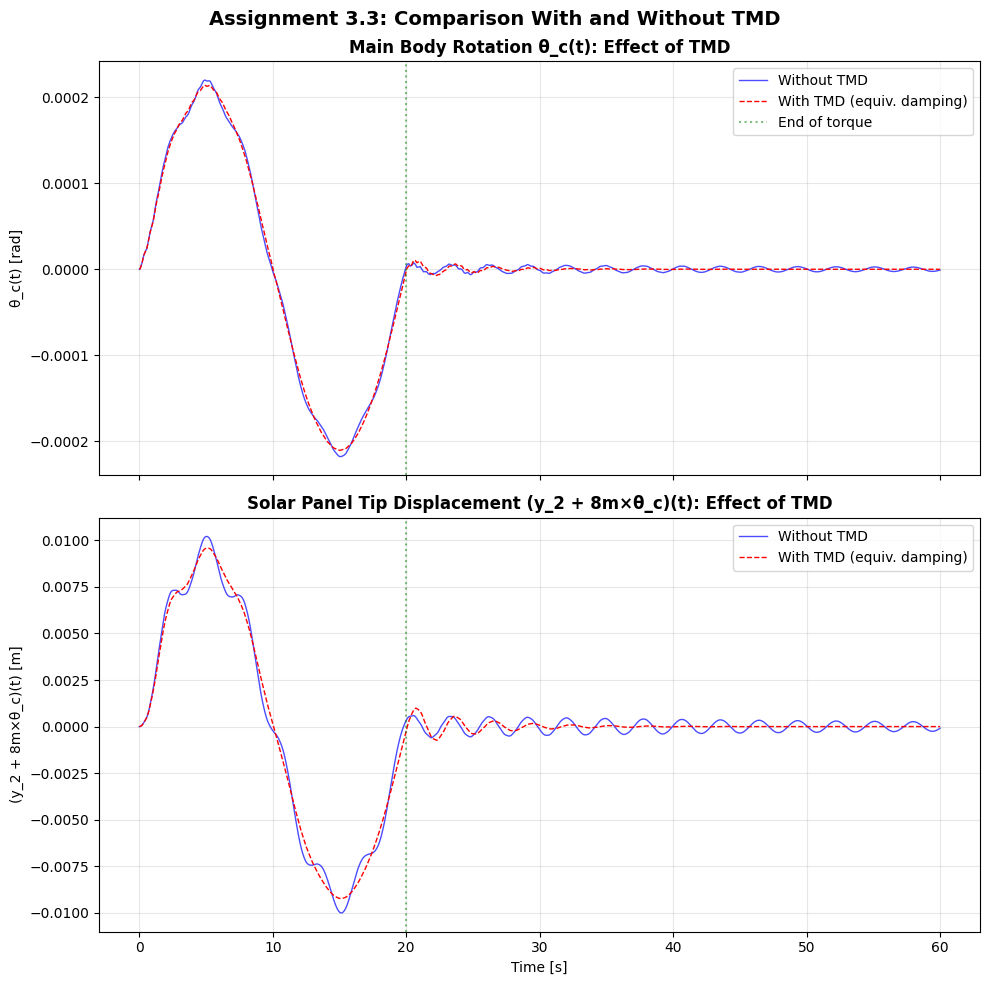

In [24]:
# Use the equivalent damping ratios from Assignment 2.4 to approximate TMD effect.

print(f"\nEquivalent damping ratios from Assignment 2.4:")
print(f"  - For (y_2-y_c)/F_c:     ξ_equiv = {xi_equiv_Fc:.4f} (vs original ξ = {xi:.4f})")
print(f"  - For (y_2+8θ_c)/M_c:    ξ_equiv = {xi_equiv_Mc:.4f}")

# Recompute θ_c(t) with equivalent damping (use the Mc-based equivalent damping)
theta_c_with_TMD = np.zeros_like(t_time)
y2_with_TMD = np.zeros_like(t_time)

# We are looking for the maximum peak in the torque transfer function.
idx_peak_Mc = np.argmax(np.abs(H_y2_plus_8theta))
freq_peak_Mc = freq[idx_peak_Mc]
# The corresponding mode number can be found
dominant_mode_Mc = np.argmin(np.abs(f_n - freq_peak_Mc)) + 1

mode_damped = dominant_mode_Mc - 1  # mode linked to the (y2+8θ)/Mc peak

for mode_idx in flexible_mode_indices:
    omega_r = omega_n[mode_idx]
    psi_r = eigenvectors[:, mode_idx]
    mu_r = psi_r.T @ M @ psi_r
    
    psi_theta_c = psi_r[idx_theta_c]
    psi_y2 = psi_r[idx_y2]
    
    # Modal force
    f_modal_r = psi_theta_c * M_c_signal

    # Use both equivalent damping estimates (from subquestion 2.4)
    if mode_idx == dominant_mode_Fc - 1:
        xi_mode = xi_equiv_Fc
    elif mode_idx == dominant_mode_Mc - 1:
        xi_mode = xi_equiv_Mc
    else:
        xi_mode = xi

    # Modal impulse response with (possibly) increased damping
    h_r_TMD = modal_impulse_response(omega_r, xi_mode, mu_r, t_time)
    
    # Convolution
    z_r_TMD = convolve(h_r_TMD, f_modal_r, mode='full')[:len(t_time)] * dt
    
    # Accumulate contributions
    theta_c_with_TMD += psi_theta_c * z_r_TMD
    y2_with_TMD += psi_y2 * z_r_TMD

# Combine for total solar panel tip motion
y2_plus_8theta_with_TMD = y2_with_TMD + L_solar * theta_c_with_TMD

# Plot comparison: With and Without TMD
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# θ_c(t)
axes[0].plot(t_time, theta_c_response, 'b-', linewidth=1, alpha=0.7, label='Without TMD')
axes[0].plot(t_time, theta_c_with_TMD, 'r--', linewidth=1, label='With TMD (equiv. damping)')
axes[0].set_ylabel('θ_c(t) [rad]')
axes[0].set_title('Main Body Rotation θ_c(t): Effect of TMD', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=20, color='green', linestyle=':', alpha=0.5, label='End of torque')
axes[0].legend()

# (y_2 + 8×θ_c)(t)
axes[1].plot(t_time, y2_plus_8theta, 'b-', linewidth=1, alpha=0.7, label='Without TMD')
axes[1].plot(t_time, y2_plus_8theta_with_TMD, 'r--', linewidth=1, label='With TMD (equiv. damping)')
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('(y_2 + 8m×θ_c)(t) [m]')
axes[1].set_title('Solar Panel Tip Displacement (y_2 + 8m×θ_c)(t): Effect of TMD', fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=20, color='green', linestyle=':', alpha=0.5)
axes[1].legend()

plt.suptitle('Assignment 3.3: Comparison With and Without TMD', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [25]:
print("""
By using the equivalent damping approximation, we can superpose the curves. We observe that the vibration amplitude decays faster with the TMD (dashed red line) than without it (blue line).

The TMD absorbs the energy of the vibration, acting as an energy sink. However, the reduction in the peak amplitude in the time domain is not as drastic as what we saw in the Frequency Domain (FRF).

This is typical for transient excitations: the TMD needs a few cycles to enter  into resonance with the main structure and start dissipating energy effectively. Nevertheless, the oscillations die out much quicker, which reduces the total number of fatigue cycles for the solar arrays.
""")


By using the equivalent damping approximation, we can superpose the curves. We observe that the vibration amplitude decays faster with the TMD (dashed red line) than without it (blue line).

The TMD absorbs the energy of the vibration, acting as an energy sink. However, the reduction in the peak amplitude in the time domain is not as drastic as what we saw in the Frequency Domain (FRF).

This is typical for transient excitations: the TMD needs a few cycles to enter  into resonance with the main structure and start dissipating energy effectively. Nevertheless, the oscillations die out much quicker, which reduces the total number of fatigue cycles for the solar arrays.



### **References**

- [1] [J. Wei, W. Liu, J. Liu, and T. Yu. Dynamic modeling and analysis of spacecraft with
multiple large flexible structures. Actuators, 12(7)(286), 2023.](https://www.dropbox.com/scl/fi/cfa9u3v53b942qbouna02/actuators-12-00286.pdf?rlkey=wtt60l3pwginy21q7oujslfkv&dl=0)
- [2] [J. Guyan. Reduction of stiffness and mass matrices. AIAA journal, 3:380–380, 1965.](https://www.dropbox.com/scl/fi/b8m5uf460gooxd6n2ao57/guyan1965.pdf?rlkey=e8fe9zp50nnk0tkhbx59op57e&dl=0)